

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'fashion_mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': True,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.1, 'epochs':120}, 
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.3, 'epochs':120},
        'resnet':{'epochs':120}         
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 14:39:52,876: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

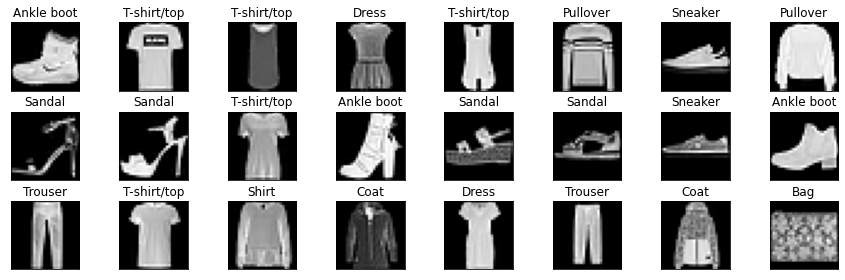

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

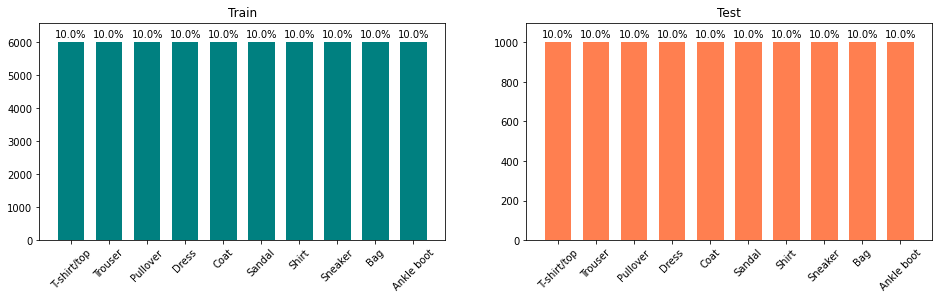

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

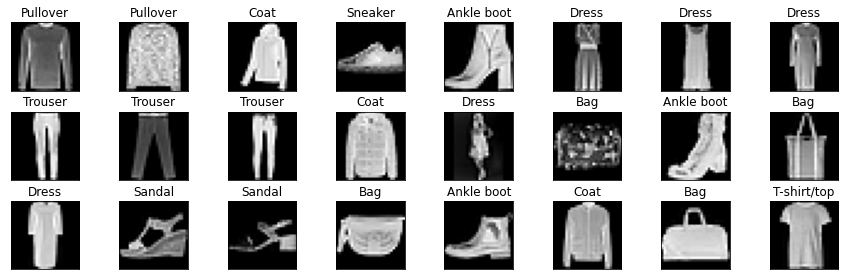

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

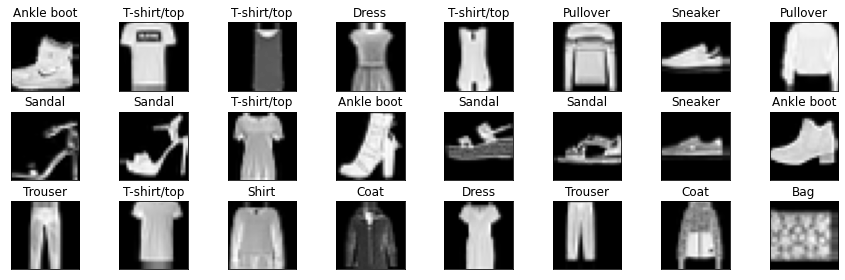

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

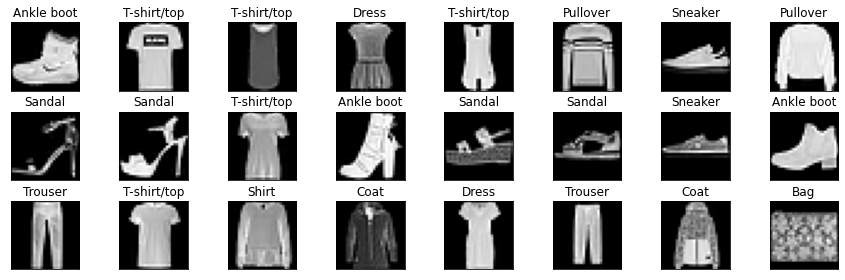

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


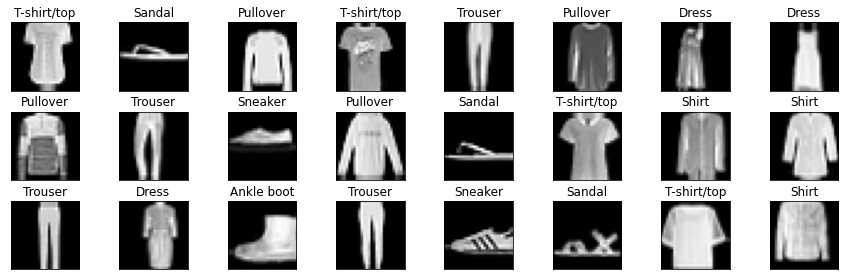

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 14:40:04,018: INFO: model_params.mlp1.dropout=0.1
2021-08-10 14:40:04,019: INFO: model_params.mlp1.layer_count=1
2021-08-10 14:40:04,019: INFO: model_params.mlp1.units=128
2021-08-10 14:40:04,086: INFO: learning_rate=0.001
2021-08-10 14:40:04,087: INFO: model_params.mlp1.clip_value=None
2021-08-10 14:40:04,107: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
2021-08-10 14:40:04,109: INFO: model_params.mlp1.epochs=120
2021-08-10 14:40:04,110: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1, monitor=val_accuracy)
2021-08-10 14:40:04,110: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 14:40:04,111: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 14:40:04,111: INFO: use LearningRate

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 22s 11ms/step - loss: 0.7402 - accuracy: 0.7247 - val_loss: 0.598

2021-08-10 14:40:26,671: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5859 - accuracy: 0.7816 - val_loss: 0.5077 - val_accuracy: 0.8093
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:40:47,541: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5409 - accuracy: 0.7987 - val_loss: 0.4678 - val_accuracy: 0.8247
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:41:08,383: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5139 - accuracy: 0.8096 - val_loss: 0.4850 - val_accuracy: 0.8110
Epoch 5/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4990 - accuracy: 0.8142 - val_loss: 0.4931 - val_accuracy: 0.8165
Epoch 6/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4895 - accuracy: 0.8183 - val_loss: 0.4222 - val_accuracy: 0.8452
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:42:09,336: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4762 - accuracy: 0.8239 - val_loss: 0.4172 - val_accuracy: 0.8478
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:42:29,796: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 8/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4696 - accuracy: 0.8252 - val_loss: 0.4231 - val_accuracy: 0.8446
Epoch 9/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4642 - accuracy: 0.8277 - val_loss: 0.4378 - val_accuracy: 0.8369
Epoch 10/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4623 - accuracy: 0.8275 - val_loss: 0.4292 - val_accuracy: 0.8435
Epoch 11/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4550 - accuracy: 0.8305 - val_loss: 0.4334 - val_accuracy: 0.8406
Epoch 12/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4510 - accuracy: 0.8338 - val_loss: 0.4123 - val_accuracy: 0.8538
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:44:10,788: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 13/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4424 - accuracy: 0.8371 - val_loss: 0.4121 - val_accuracy: 0.8512
Epoch 14/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4411 - accuracy: 0.8365 - val_loss: 0.4022 - val_accuracy: 0.8562
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:44:51,268: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 15/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4390 - accuracy: 0.8374 - val_loss: 0.4161 - val_accuracy: 0.8482
Epoch 16/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4357 - accuracy: 0.8389 - val_loss: 0.4113 - val_accuracy: 0.8505
Epoch 17/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4304 - accuracy: 0.8402 - val_loss: 0.4013 - val_accuracy: 0.8521
Epoch 18/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4332 - accuracy: 0.8396 - val_loss: 0.3967 - val_accuracy: 0.8561
Epoch 19/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4278 - accuracy: 0.8418 - val_loss: 0.3888 - val_accuracy: 0.8574
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:46:31,063: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 20/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4271 - accuracy: 0.8424 - val_loss: 0.3871 - val_accuracy: 0.8624
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:46:51,420: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 21/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4245 - accuracy: 0.8426 - val_loss: 0.4076 - val_accuracy: 0.8525
Epoch 22/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4223 - accuracy: 0.8449 - val_loss: 0.4003 - val_accuracy: 0.8565
Epoch 23/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4220 - accuracy: 0.8440 - val_loss: 0.3980 - val_accuracy: 0.8573
Epoch 24/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4191 - accuracy: 0.8457 - val_loss: 0.4045 - val_accuracy: 0.8543
Epoch 25/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4209 - accuracy: 0.8432 - val_loss: 0.3902 - val_accuracy: 0.8626
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:48:30,824: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 26/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4149 - accuracy: 0.8466 - val_loss: 0.3896 - val_accuracy: 0.8592
Epoch 27/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4149 - accuracy: 0.8468 - val_loss: 0.4198 - val_accuracy: 0.8484
Epoch 28/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4155 - accuracy: 0.8461 - val_loss: 0.3900 - val_accuracy: 0.8597
Epoch 29/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4137 - accuracy: 0.8477 - val_loss: 0.3966 - val_accuracy: 0.8583
Epoch 30/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4095 - accuracy: 0.8479 - val_loss: 0.4002 - val_accuracy: 0.8578
Epoch 31/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4081 - accuracy: 0.8490 - val_loss: 0.3772 - val_accuracy: 0.8638
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 14:50:30,371: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 32/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4095 - accuracy: 0.8474 - val_loss: 0.3872 - val_accuracy: 0.8623
Epoch 33/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4095 - accuracy: 0.8487 - val_loss: 0.3866 - val_accuracy: 0.8583
Epoch 34/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4098 - accuracy: 0.8482 - val_loss: 0.3914 - val_accuracy: 0.8580
Epoch 35/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4064 - accuracy: 0.8498 - val_loss: 0.3912 - val_accuracy: 0.8566
Epoch 36/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4051 - accuracy: 0.8493 - val_loss: 0.3930 - val_accuracy: 0.8589
Epoch 37/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4067 - accuracy: 0.8491 - val_loss: 0.3823 - val_accuracy: 0.8632
Epoch 38/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.4059 - accuracy: 0.8509 - val_

2021-08-10 14:53:48,078: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 42/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4025 - accuracy: 0.8511 - val_loss: 0.3752 - val_accuracy: 0.8685
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:54:08,543: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 43/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3983 - accuracy: 0.8526 - val_loss: 0.4010 - val_accuracy: 0.8543
Epoch 44/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4010 - accuracy: 0.8518 - val_loss: 0.3820 - val_accuracy: 0.8645
Epoch 45/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4009 - accuracy: 0.8515 - val_loss: 0.3864 - val_accuracy: 0.8608
Epoch 46/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3972 - accuracy: 0.8533 - val_loss: 0.3863 - val_accuracy: 0.8624
Epoch 47/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3974 - accuracy: 0.8542 - val_loss: 0.3781 - val_accuracy: 0.8645
Epoch 48/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3983 - accuracy: 0.8533 - val_loss: 0.3747 - val_accuracy: 0.8700
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 14:56:08,395: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 49/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3946 - accuracy: 0.8538 - val_loss: 0.3840 - val_accuracy: 0.8622
Epoch 50/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3954 - accuracy: 0.8531 - val_loss: 0.3695 - val_accuracy: 0.8710
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 14:56:48,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 51/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3940 - accuracy: 0.8545 - val_loss: 0.3803 - val_accuracy: 0.8628
Epoch 52/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3962 - accuracy: 0.8535 - val_loss: 0.3801 - val_accuracy: 0.8678
Epoch 53/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3959 - accuracy: 0.8539 - val_loss: 0.3709 - val_accuracy: 0.8664
Epoch 54/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3919 - accuracy: 0.8553 - val_loss: 0.3659 - val_accuracy: 0.8710
Epoch 55/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3961 - accuracy: 0.8527 - val_loss: 0.3750 - val_accuracy: 0.8670
Epoch 56/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3937 - accuracy: 0.8548 - val_loss: 0.3689 - val_accuracy: 0.8703
Epoch 57/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3937 - accuracy: 0.8540 - val_

2021-08-10 15:00:27,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 62/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3608 - accuracy: 0.8684 - val_loss: 0.3559 - val_accuracy: 0.8754
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:00:47,867: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 63/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3600 - accuracy: 0.8679 - val_loss: 0.3544 - val_accuracy: 0.8776
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:01:08,389: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 64/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3591 - accuracy: 0.8692 - val_loss: 0.3537 - val_accuracy: 0.8746
Epoch 65/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3586 - accuracy: 0.8691 - val_loss: 0.3527 - val_accuracy: 0.8770
Epoch 66/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3580 - accuracy: 0.8669 - val_loss: 0.3530 - val_accuracy: 0.8782
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:02:08,601: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 67/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3578 - accuracy: 0.8679 - val_loss: 0.3512 - val_accuracy: 0.8758
Epoch 68/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3550 - accuracy: 0.8700 - val_loss: 0.3510 - val_accuracy: 0.8764
Epoch 69/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3567 - accuracy: 0.8690 - val_loss: 0.3556 - val_accuracy: 0.8766
Epoch 70/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3576 - accuracy: 0.8686 - val_loss: 0.3500 - val_accuracy: 0.8785
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:03:28,606: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 71/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3572 - accuracy: 0.8689 - val_loss: 0.3521 - val_accuracy: 0.8782
Epoch 72/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3535 - accuracy: 0.8695 - val_loss: 0.3500 - val_accuracy: 0.8785
Epoch 73/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3526 - accuracy: 0.8700 - val_loss: 0.3498 - val_accuracy: 0.8771
Epoch 74/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3565 - accuracy: 0.8676 - val_loss: 0.3489 - val_accuracy: 0.8789
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:04:48,540: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 75/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3553 - accuracy: 0.8683 - val_loss: 0.3501 - val_accuracy: 0.8773
Epoch 76/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3504 - accuracy: 0.8712 - val_loss: 0.3507 - val_accuracy: 0.8779
Epoch 77/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3548 - accuracy: 0.8685 - val_loss: 0.3483 - val_accuracy: 0.8766
Epoch 78/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3539 - accuracy: 0.8708 - val_loss: 0.3484 - val_accuracy: 0.8771
Epoch 79/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3537 - accuracy: 0.8693 - val_loss: 0.3479 - val_accuracy: 0.8771
Epoch 80/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3557 - accuracy: 0.8685 - val_loss: 0.3503 - val_accuracy: 0.8778
Epoch 81/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3544 - accuracy: 0.8697 - val_

2021-08-10 15:08:27,746: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 86/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3480 - accuracy: 0.8702 - val_loss: 0.3475 - val_accuracy: 0.8773
Epoch 87/120
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3486 - accuracy: 0.8712 - val_loss: 0.3479 - val_accuracy: 0.8790
Epoch 88/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3518 - accuracy: 0.8698 - val_loss: 0.3482 - val_accuracy: 0.8762
Epoch 89/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3491 - accuracy: 0.8714 - val_loss: 0.3483 - val_accuracy: 0.8806
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


2021-08-10 15:09:46,601: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1/assets


Epoch 90/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3514 - accuracy: 0.8713 - val_loss: 0.3481 - val_accuracy: 0.8795
Epoch 91/120
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3514 - accuracy: 0.8705 - val_loss: 0.3473 - val_accuracy: 0.8791
Epoch 92/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3488 - accuracy: 0.8707 - val_loss: 0.3468 - val_accuracy: 0.8786
Epoch 93/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3491 - accuracy: 0.8710 - val_loss: 0.3470 - val_accuracy: 0.8778
Epoch 94/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3512 - accuracy: 0.8717 - val_loss: 0.3472 - val_accuracy: 0.8783
Epoch 95/120
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3511 - accuracy: 0.8718 - val_loss: 0.3473 - val_accuracy: 0.8788
Epoch 96/120
1875/1875 [========

2021-08-10 15:19:55,778: INFO: finish training [elapsed time: 2391.67 seconds]


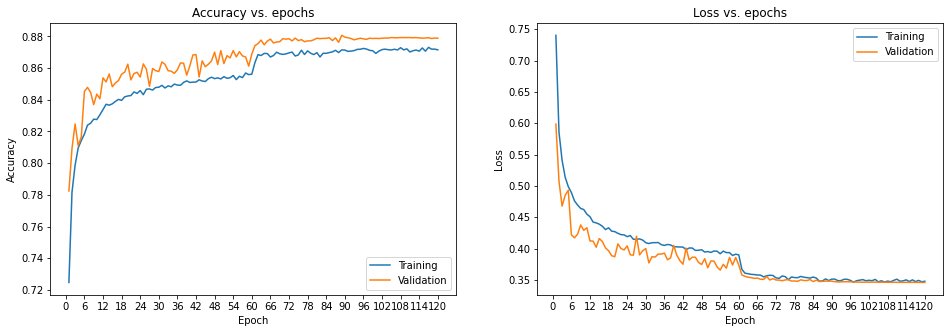

2021-08-10 15:19:56,351: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 15:20:02,035: INFO: test loss:0.3483
2021-08-10 15:20:02,036: INFO: test accuracy:0.8806
2021-08-10 15:20:02,038: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 15:20:02,040: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 15:20:02,041: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 15:20:02,042: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 15:20:02,043: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 15:20:03,053: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


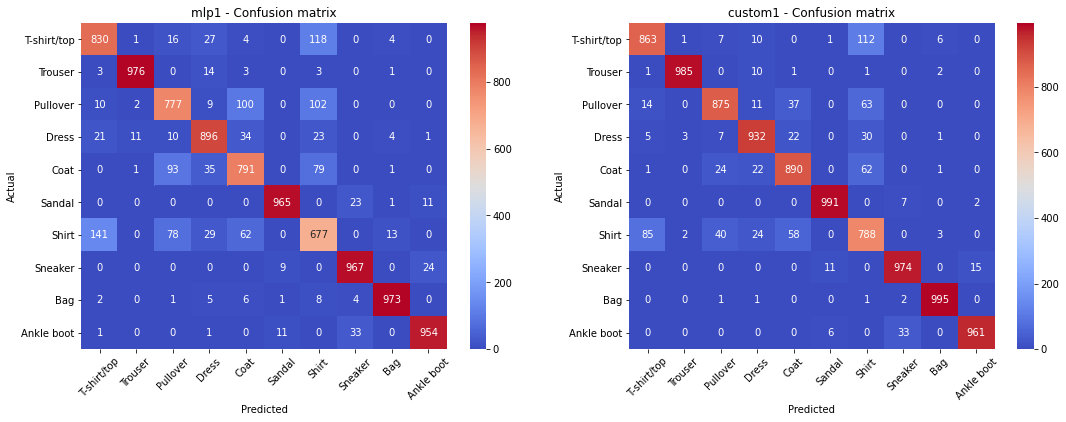

2021-08-10 15:20:07,116: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 15:20:08,214: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 15:20:08,216: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
2021-08-10 15:20:09,066: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


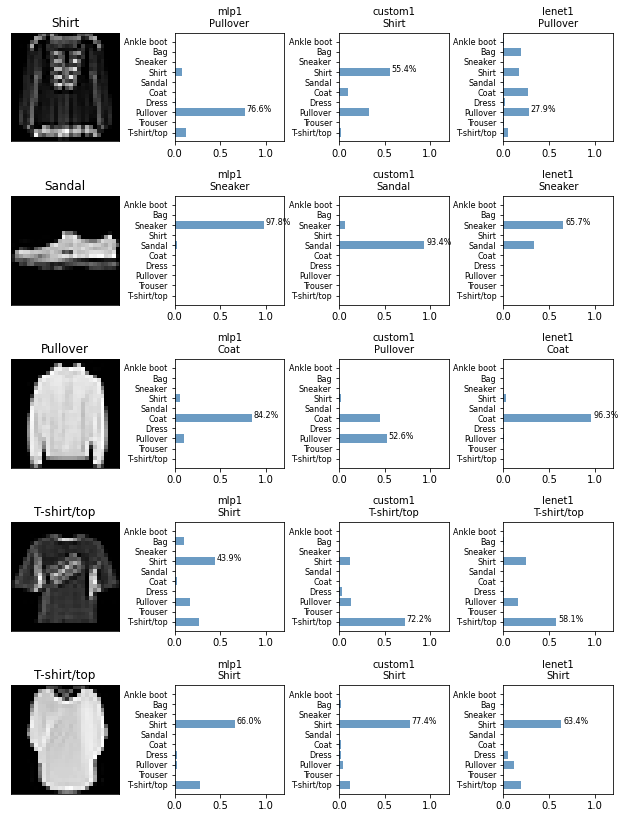

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,73162,3746.9,2021-08-10 11:14,0.1630,0.2050,0.9382,0.9254,0.9972,0.9959
2,lenet1,61750,2799.2,NaN,0.1747,0.2236,0.9335,0.9173,0.9967,0.9951
3,mlp1,101770,2391.2,2021-08-10 15:20,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 15:20:12,699: INFO: model_params.lenet1.dropout=0.1
2021-08-10 15:20:12,782: INFO: learning_rate=0.001
2021-08-10 15:20:12,783: INFO: model_params.lenet1.clip_value=None
2021-08-10 15:20:12,788: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
2021-08-10 15:20:12,793: INFO: model_params.lenet1.epochs=120
2021-08-10 15:20:12,794: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1, monitor=val_accuracy)
2021-08-10 15:20:12,795: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 15:20:12,795: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 15:20:12,796: INFO: use LearningRateScheduler()
2021-08-10 15:20:12,796: INFO: steps_per_epoch=1875
2021-08-10 15:20:12,797: INFO: start training
20

Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64   

2021-08-10 15:20:35,920: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 2/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4760 - accuracy: 0.8196 - val_loss: 0.4066 - val_accuracy: 0.8543
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:20:58,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 3/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4347 - accuracy: 0.8361 - val_loss: 0.4358 - val_accuracy: 0.8253
Epoch 4/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4120 - accuracy: 0.8451 - val_loss: 0.3493 - val_accuracy: 0.8698
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:21:41,056: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 5/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3997 - accuracy: 0.8502 - val_loss: 0.3455 - val_accuracy: 0.8711
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:22:03,273: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 6/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3832 - accuracy: 0.8563 - val_loss: 0.3306 - val_accuracy: 0.8776
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:22:25,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 7/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3785 - accuracy: 0.8573 - val_loss: 0.3433 - val_accuracy: 0.8692
Epoch 8/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3692 - accuracy: 0.8604 - val_loss: 0.3160 - val_accuracy: 0.8808
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:23:08,364: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 9/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3616 - accuracy: 0.8641 - val_loss: 0.3059 - val_accuracy: 0.8893
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:23:30,570: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 10/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3557 - accuracy: 0.8662 - val_loss: 0.3163 - val_accuracy: 0.8830
Epoch 11/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3519 - accuracy: 0.8679 - val_loss: 0.3566 - val_accuracy: 0.8628
Epoch 12/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3461 - accuracy: 0.8703 - val_loss: 0.3108 - val_accuracy: 0.8867
Epoch 13/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3417 - accuracy: 0.8711 - val_loss: 0.2951 - val_accuracy: 0.8915
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:24:53,967: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 14/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3375 - accuracy: 0.8729 - val_loss: 0.3324 - val_accuracy: 0.8789
Epoch 15/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3372 - accuracy: 0.8727 - val_loss: 0.2885 - val_accuracy: 0.8942
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:25:37,237: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 16/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3318 - accuracy: 0.8739 - val_loss: 0.3344 - val_accuracy: 0.8746
Epoch 17/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3284 - accuracy: 0.8748 - val_loss: 0.2835 - val_accuracy: 0.8958
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:26:19,972: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 18/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3269 - accuracy: 0.8766 - val_loss: 0.2776 - val_accuracy: 0.8960
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:26:42,031: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 19/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3241 - accuracy: 0.8788 - val_loss: 0.2791 - val_accuracy: 0.8956
Epoch 20/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3215 - accuracy: 0.8796 - val_loss: 0.3099 - val_accuracy: 0.8823
Epoch 21/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3168 - accuracy: 0.8798 - val_loss: 0.2812 - val_accuracy: 0.8956
Epoch 22/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3165 - accuracy: 0.8811 - val_loss: 0.2727 - val_accuracy: 0.9001
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:28:05,099: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 23/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3154 - accuracy: 0.8814 - val_loss: 0.2704 - val_accuracy: 0.8994
Epoch 24/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3101 - accuracy: 0.8833 - val_loss: 0.2724 - val_accuracy: 0.8950
Epoch 25/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3093 - accuracy: 0.8833 - val_loss: 0.2640 - val_accuracy: 0.9020
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:29:08,489: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 26/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3080 - accuracy: 0.8848 - val_loss: 0.2759 - val_accuracy: 0.8972
Epoch 27/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3047 - accuracy: 0.8863 - val_loss: 0.2717 - val_accuracy: 0.9014
Epoch 28/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3027 - accuracy: 0.8859 - val_loss: 0.2983 - val_accuracy: 0.8840
Epoch 29/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3040 - accuracy: 0.8846 - val_loss: 0.3023 - val_accuracy: 0.8877
Epoch 30/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2997 - accuracy: 0.8867 - val_loss: 0.2936 - val_accuracy: 0.8897
Epoch 31/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2996 - accuracy: 0.8860 - val_loss: 0.2700 - val_accuracy: 0.8988
Epoch 32/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2970 - accuracy: 0.8870 - val_

2021-08-10 15:33:36,653: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 39/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2912 - accuracy: 0.8897 - val_loss: 0.2942 - val_accuracy: 0.8866
Epoch 40/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2908 - accuracy: 0.8894 - val_loss: 0.2734 - val_accuracy: 0.8964
Epoch 41/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2906 - accuracy: 0.8913 - val_loss: 0.2674 - val_accuracy: 0.8993
Epoch 42/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2894 - accuracy: 0.8904 - val_loss: 0.2738 - val_accuracy: 0.8954
Epoch 43/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2869 - accuracy: 0.8915 - val_loss: 0.2632 - val_accuracy: 0.9005
Epoch 44/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2867 - accuracy: 0.8923 - val_loss: 0.2756 - val_accuracy: 0.8963
Epoch 45/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2849 - accuracy: 0.8932 - val_

2021-08-10 15:39:23,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 56/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2794 - accuracy: 0.8944 - val_loss: 0.2714 - val_accuracy: 0.8972
Epoch 57/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2783 - accuracy: 0.8960 - val_loss: 0.2639 - val_accuracy: 0.8991
Epoch 58/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2805 - accuracy: 0.8958 - val_loss: 0.2450 - val_accuracy: 0.9078
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:40:27,721: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 59/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2753 - accuracy: 0.8974 - val_loss: 0.2491 - val_accuracy: 0.9051
Epoch 60/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2783 - accuracy: 0.8967 - val_loss: 0.2537 - val_accuracy: 0.9057
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2620 - accuracy: 0.9008 - val_loss: 0.2375 - val_accuracy: 0.9094
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:41:31,271: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 62/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2546 - accuracy: 0.9043 - val_loss: 0.2381 - val_accuracy: 0.9083
Epoch 63/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2553 - accuracy: 0.9039 - val_loss: 0.2410 - val_accuracy: 0.9091
Epoch 64/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2546 - accuracy: 0.9037 - val_loss: 0.2349 - val_accuracy: 0.9103
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:42:34,798: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 65/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2528 - accuracy: 0.9041 - val_loss: 0.2438 - val_accuracy: 0.9094
Epoch 66/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2549 - accuracy: 0.9039 - val_loss: 0.2329 - val_accuracy: 0.9121
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:43:17,602: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 67/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2503 - accuracy: 0.9059 - val_loss: 0.2347 - val_accuracy: 0.9114
Epoch 68/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2483 - accuracy: 0.9053 - val_loss: 0.2436 - val_accuracy: 0.9088
Epoch 69/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2507 - accuracy: 0.9060 - val_loss: 0.2343 - val_accuracy: 0.9108
Epoch 70/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2516 - accuracy: 0.9060 - val_loss: 0.2399 - val_accuracy: 0.9103
Epoch 71/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2499 - accuracy: 0.9068 - val_loss: 0.2405 - val_accuracy: 0.9102
Epoch 72/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2492 - accuracy: 0.9062 - val_loss: 0.2355 - val_accuracy: 0.9128
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 15:45:23,126: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 73/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2500 - accuracy: 0.9064 - val_loss: 0.2328 - val_accuracy: 0.9108
Epoch 74/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2486 - accuracy: 0.9063 - val_loss: 0.2319 - val_accuracy: 0.9129
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


2021-08-10 15:46:05,790: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 75/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2494 - accuracy: 0.9068 - val_loss: 0.2322 - val_accuracy: 0.9129
Epoch 76/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2494 - accuracy: 0.9065 - val_loss: 0.2307 - val_accuracy: 0.9128
Epoch 77/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2472 - accuracy: 0.9067 - val_loss: 0.2317 - val_accuracy: 0.9122
Epoch 78/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2467 - accuracy: 0.9062 - val_loss: 0.2322 - val_accuracy: 0.9125
Epoch 79/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2469 - accuracy: 0.9066 - val_loss: 0.2309 - val_accuracy: 0.9122
Epoch 80/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2492 - accuracy: 0.9068 - val_loss: 0.2313 - val_accuracy: 0.9129
Epoch 81/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2432 - accuracy: 0.9074 - val_

2021-08-10 15:49:11,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1/assets


Epoch 84/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2461 - accuracy: 0.9084 - val_loss: 0.2308 - val_accuracy: 0.9124
Epoch 85/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2460 - accuracy: 0.9067 - val_loss: 0.2361 - val_accuracy: 0.9126
Epoch 86/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2435 - accuracy: 0.9083 - val_loss: 0.2358 - val_accuracy: 0.9126
Epoch 87/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2454 - accuracy: 0.9072 - val_loss: 0.2349 - val_accuracy: 0.9119
Epoch 88/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2466 - accuracy: 0.9076 - val_loss: 0.2371 - val_accuracy: 0.9105
Epoch 89/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2456 - accuracy: 0.9077 - val_loss: 0.2302 - val_accuracy: 0.9132
Epoch 90/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2436 - accuracy: 0.9078 - val_

2021-08-10 16:01:50,871: INFO: finish training [elapsed time: 2498.07 seconds]


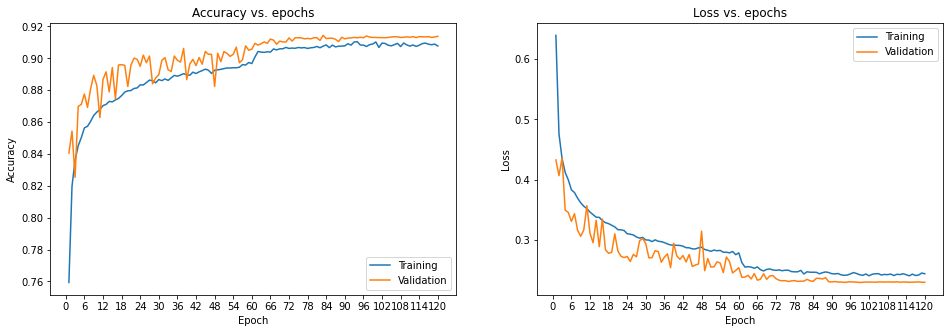

2021-08-10 16:01:51,421: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 16:02:00,611: INFO: test loss:0.2320
2021-08-10 16:02:00,612: INFO: test accuracy:0.9144
2021-08-10 16:02:00,614: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 16:02:00,615: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 16:02:00,615: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:02:00,616: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:02:00,617: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 16:02:01,576: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


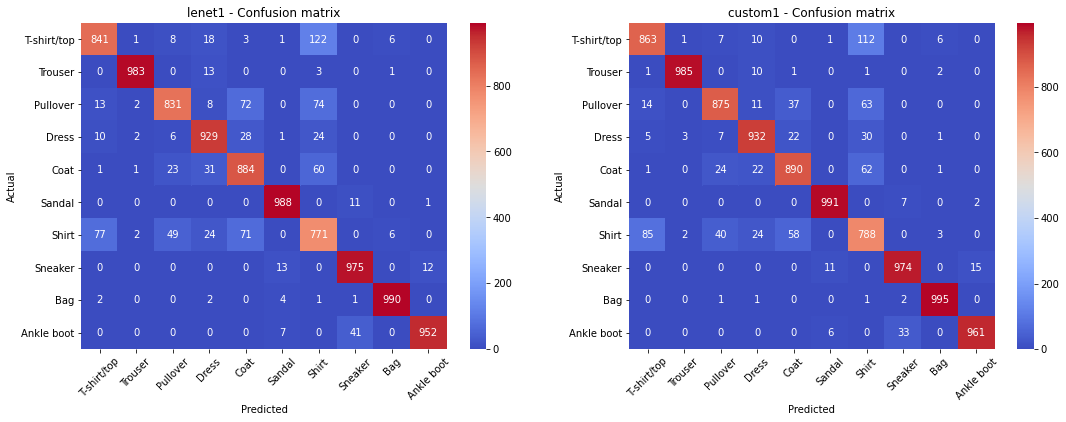

2021-08-10 16:02:05,234: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 16:02:06,507: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:02:06,509: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
2021-08-10 16:02:06,785: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


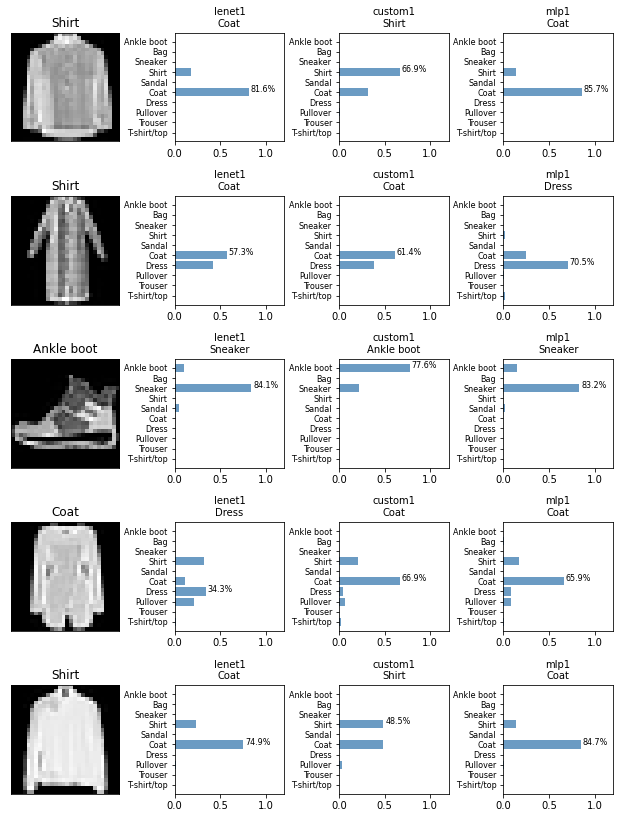

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,73162,3746.9,2021-08-10 11:14,0.1630,0.2050,0.9382,0.9254,0.9972,0.9959
2,lenet1,61750,2497.6,2021-08-10 16:02,0.1795,0.2320,0.9315,0.9144,0.9967,0.9949
3,mlp1,101770,2391.2,2021-08-10 15:20,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 16:02:10,266: INFO: model_params.custom1.dropout=0.2
2021-08-10 16:02:10,360: INFO: learning_rate=0.001
2021-08-10 16:02:10,361: INFO: model_params.custom1.clip_value=None
2021-08-10 16:02:10,367: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1
2021-08-10 16:02:10,373: INFO: model_params.custom1.epochs=120
2021-08-10 16:02:10,373: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1, monitor=val_accuracy)
2021-08-10 16:02:10,374: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 16:02:10,374: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 16:02:10,375: INFO: use LearningRateScheduler()
2021-08-10 16:02:10,376: INFO: steps_per_epoch=1875
2021-08-10 16:02:10,376: INFO: start traini

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256 

2021-08-10 16:02:34,326: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 2/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4881 - accuracy: 0.8194 - val_loss: 0.4505 - val_accuracy: 0.8313
Epoch 3/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4302 - accuracy: 0.8401 - val_loss: 0.3632 - val_accuracy: 0.8622
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:03:17,852: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 4/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4028 - accuracy: 0.8494 - val_loss: 0.3111 - val_accuracy: 0.8847
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:03:41,265: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 5/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3853 - accuracy: 0.8575 - val_loss: 0.3682 - val_accuracy: 0.8621
Epoch 6/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3704 - accuracy: 0.8626 - val_loss: 0.3451 - val_accuracy: 0.8716
Epoch 7/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3568 - accuracy: 0.8671 - val_loss: 0.3327 - val_accuracy: 0.8781
Epoch 8/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3531 - accuracy: 0.8683 - val_loss: 0.2927 - val_accuracy: 0.8890
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:05:05,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 9/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3430 - accuracy: 0.8723 - val_loss: 0.2842 - val_accuracy: 0.8942
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:05:28,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 10/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3366 - accuracy: 0.8747 - val_loss: 0.2933 - val_accuracy: 0.8892
Epoch 11/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3333 - accuracy: 0.8763 - val_loss: 0.2854 - val_accuracy: 0.8923
Epoch 12/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3273 - accuracy: 0.8790 - val_loss: 0.2696 - val_accuracy: 0.8997
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:06:33,420: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 13/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3208 - accuracy: 0.8813 - val_loss: 0.2794 - val_accuracy: 0.8940
Epoch 14/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3173 - accuracy: 0.8835 - val_loss: 0.2623 - val_accuracy: 0.9038
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:07:17,139: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 15/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3158 - accuracy: 0.8830 - val_loss: 0.2758 - val_accuracy: 0.8943
Epoch 16/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3110 - accuracy: 0.8857 - val_loss: 0.2683 - val_accuracy: 0.9005
Epoch 17/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3094 - accuracy: 0.8864 - val_loss: 0.2637 - val_accuracy: 0.9027
Epoch 18/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3058 - accuracy: 0.8878 - val_loss: 0.2722 - val_accuracy: 0.8971
Epoch 19/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3036 - accuracy: 0.8881 - val_loss: 0.2756 - val_accuracy: 0.8984
Epoch 20/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2990 - accuracy: 0.8888 - val_loss: 0.2549 - val_accuracy: 0.9040
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 16:09:23,138: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 21/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2968 - accuracy: 0.8907 - val_loss: 0.2721 - val_accuracy: 0.9017
Epoch 22/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2956 - accuracy: 0.8919 - val_loss: 0.2562 - val_accuracy: 0.9075
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:10:07,086: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 23/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2951 - accuracy: 0.8912 - val_loss: 0.2500 - val_accuracy: 0.9062
Epoch 24/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2916 - accuracy: 0.8924 - val_loss: 0.2918 - val_accuracy: 0.8899
Epoch 25/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2914 - accuracy: 0.8921 - val_loss: 0.2492 - val_accuracy: 0.9092
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:11:11,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 26/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2851 - accuracy: 0.8942 - val_loss: 0.2607 - val_accuracy: 0.9041
Epoch 27/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2877 - accuracy: 0.8942 - val_loss: 0.2410 - val_accuracy: 0.9110
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:11:55,374: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 28/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2846 - accuracy: 0.8956 - val_loss: 0.2711 - val_accuracy: 0.8969
Epoch 29/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2847 - accuracy: 0.8957 - val_loss: 0.2567 - val_accuracy: 0.9048
Epoch 30/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2801 - accuracy: 0.8978 - val_loss: 0.2529 - val_accuracy: 0.9025
Epoch 31/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2824 - accuracy: 0.8956 - val_loss: 0.2644 - val_accuracy: 0.9011
Epoch 32/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2814 - accuracy: 0.8946 - val_loss: 0.2776 - val_accuracy: 0.8969
Epoch 33/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2816 - accuracy: 0.8963 - val_loss: 0.2416 - val_accuracy: 0.9128
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 16:14:01,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 34/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2773 - accuracy: 0.8975 - val_loss: 0.2334 - val_accuracy: 0.9138
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:14:25,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 35/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2765 - accuracy: 0.8969 - val_loss: 0.2374 - val_accuracy: 0.9138
Epoch 36/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2722 - accuracy: 0.9003 - val_loss: 0.2680 - val_accuracy: 0.8985
Epoch 37/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2709 - accuracy: 0.9010 - val_loss: 0.2396 - val_accuracy: 0.9124
Epoch 38/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2710 - accuracy: 0.8997 - val_loss: 0.2457 - val_accuracy: 0.9113
Epoch 39/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2701 - accuracy: 0.8994 - val_loss: 0.2486 - val_accuracy: 0.9080
Epoch 40/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2710 - accuracy: 0.8986 - val_loss: 0.2785 - val_accuracy: 0.8932
Epoch 41/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2699 - accuracy: 0.9001 - val_

2021-08-10 16:17:13,163: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 43/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2676 - accuracy: 0.9021 - val_loss: 0.2512 - val_accuracy: 0.9080
Epoch 44/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2681 - accuracy: 0.9017 - val_loss: 0.2273 - val_accuracy: 0.9168
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:17:57,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 45/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2647 - accuracy: 0.9025 - val_loss: 0.2312 - val_accuracy: 0.9132
Epoch 46/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2644 - accuracy: 0.9040 - val_loss: 0.2698 - val_accuracy: 0.8958
Epoch 47/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2625 - accuracy: 0.9038 - val_loss: 0.2230 - val_accuracy: 0.9205
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:19:01,758: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 48/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2634 - accuracy: 0.9026 - val_loss: 0.2428 - val_accuracy: 0.9098
Epoch 49/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2626 - accuracy: 0.9030 - val_loss: 0.2772 - val_accuracy: 0.8936
Epoch 50/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2648 - accuracy: 0.9021 - val_loss: 0.2436 - val_accuracy: 0.9101
Epoch 51/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2619 - accuracy: 0.9034 - val_loss: 0.2212 - val_accuracy: 0.9183
Epoch 52/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2604 - accuracy: 0.9034 - val_loss: 0.2390 - val_accuracy: 0.9145
Epoch 53/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2596 - accuracy: 0.9044 - val_loss: 0.2383 - val_accuracy: 0.9096
Epoch 54/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2590 - accuracy: 0.9046 - val_

2021-08-10 16:24:15,958: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 63/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2366 - accuracy: 0.9129 - val_loss: 0.2198 - val_accuracy: 0.9202
Epoch 64/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2336 - accuracy: 0.9139 - val_loss: 0.2206 - val_accuracy: 0.9205
Epoch 65/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2309 - accuracy: 0.9153 - val_loss: 0.2149 - val_accuracy: 0.9229
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:25:21,305: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 66/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2324 - accuracy: 0.9144 - val_loss: 0.2165 - val_accuracy: 0.9211
Epoch 67/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2338 - accuracy: 0.9141 - val_loss: 0.2164 - val_accuracy: 0.9214
Epoch 68/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2320 - accuracy: 0.9151 - val_loss: 0.2195 - val_accuracy: 0.9201
Epoch 69/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2314 - accuracy: 0.9151 - val_loss: 0.2108 - val_accuracy: 0.9245
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:26:46,711: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 70/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2313 - accuracy: 0.9151 - val_loss: 0.2076 - val_accuracy: 0.9251
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


2021-08-10 16:27:10,059: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 71/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2283 - accuracy: 0.9155 - val_loss: 0.2097 - val_accuracy: 0.9235
Epoch 72/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2303 - accuracy: 0.9151 - val_loss: 0.2099 - val_accuracy: 0.9244
Epoch 73/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2288 - accuracy: 0.9165 - val_loss: 0.2105 - val_accuracy: 0.9246
Epoch 74/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2270 - accuracy: 0.9172 - val_loss: 0.2098 - val_accuracy: 0.9239
Epoch 75/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2298 - accuracy: 0.9151 - val_loss: 0.2108 - val_accuracy: 0.9229
Epoch 76/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2261 - accuracy: 0.9158 - val_loss: 0.2114 - val_accuracy: 0.9234
Epoch 77/120
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2278 - accuracy: 0.9154 - val_

2021-08-10 16:34:05,067: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1/assets


Epoch 91/120
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 3.16e-05.
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2259 - accuracy: 0.9176 - val_loss: 0.2087 - val_accuracy: 0.9246
Epoch 92/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2238 - accuracy: 0.9174 - val_loss: 0.2078 - val_accuracy: 0.9255
Epoch 93/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2226 - accuracy: 0.9181 - val_loss: 0.2089 - val_accuracy: 0.9249
Epoch 94/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2228 - accuracy: 0.9185 - val_loss: 0.2091 - val_accuracy: 0.9251
Epoch 95/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2218 - accuracy: 0.9172 - val_loss: 0.2071 - val_accuracy: 0.9253
Epoch 96/120
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2219 - accuracy: 0.9183 - val_loss: 0.2096 - val_accuracy: 0.9244
Epoch 97/120
1875/1875 [======

2021-08-10 16:44:33,752: INFO: finish training [elapsed time: 2543.38 seconds]


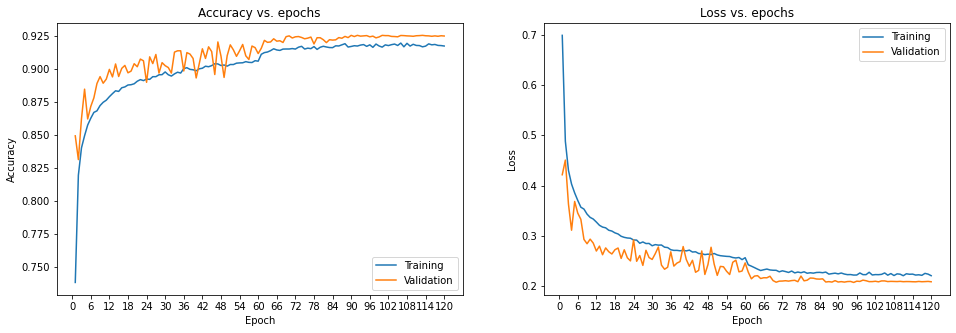

2021-08-10 16:44:34,313: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 16:44:46,965: INFO: test loss:0.2080
2021-08-10 16:44:46,966: INFO: test accuracy:0.9255
2021-08-10 16:44:46,967: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 16:44:46,969: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 16:44:46,970: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:44:46,971: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:44:46,971: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 16:44:47,862: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


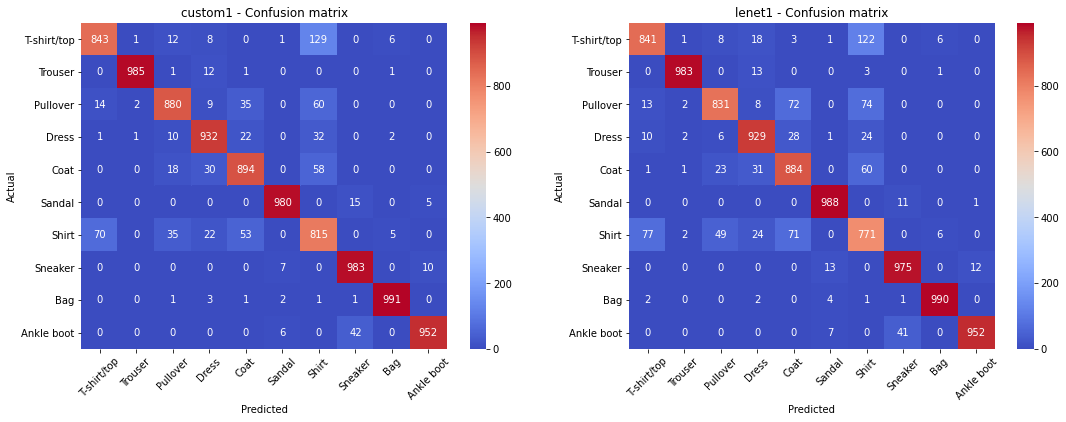

2021-08-10 16:44:51,898: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 16:44:52,737: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 16:44:52,739: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
2021-08-10 16:44:53,025: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


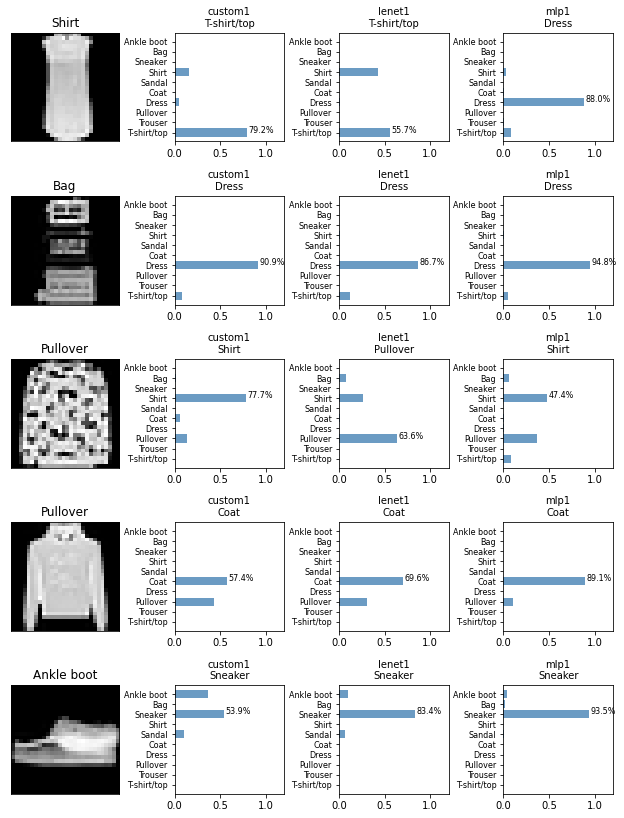

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,73162,2542.9,2021-08-10 16:44,0.1595,0.2080,0.9392,0.9255,0.9973,0.9958
2,lenet1,61750,2497.6,2021-08-10 16:02,0.1795,0.2320,0.9315,0.9144,0.9967,0.9949
3,mlp1,101770,2391.2,2021-08-10 15:20,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 16:44:56,683: INFO: model_params.vgg8.dropout=0.3
2021-08-10 16:44:56,844: INFO: learning_rate=0.001
2021-08-10 16:44:56,845: INFO: model_params.vgg8.clip_value=None
2021-08-10 16:44:56,851: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8
2021-08-10 16:44:56,860: INFO: model_params.vgg8.epochs=120
2021-08-10 16:44:56,860: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8, monitor=val_accuracy)
2021-08-10 16:44:56,861: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 16:44:56,862: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 16:44:56,862: INFO: use LearningRateScheduler()
2021-08-10 16:44:56,863: INFO: steps_per_epoch=1875
2021-08-10 16:44:56,863: INFO: start training
2021-08-10 1

Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 28, 28, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 28, 28, 64)        0      

2021-08-10 16:45:32,994: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 2/120
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4472 - accuracy: 0.8365 - val_loss: 0.3572 - val_accuracy: 0.8698
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:46:07,520: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 3/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.3798 - accuracy: 0.8641 - val_loss: 0.3070 - val_accuracy: 0.8886
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:46:41,165: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 4/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.3409 - accuracy: 0.8775 - val_loss: 0.2608 - val_accuracy: 0.9068
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:47:14,449: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 5/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.3136 - accuracy: 0.8881 - val_loss: 0.2758 - val_accuracy: 0.8989
Epoch 6/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2911 - accuracy: 0.8956 - val_loss: 0.2451 - val_accuracy: 0.9129
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:48:19,088: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 7/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2728 - accuracy: 0.9021 - val_loss: 0.2369 - val_accuracy: 0.9152
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:48:52,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 8/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2592 - accuracy: 0.9075 - val_loss: 0.2205 - val_accuracy: 0.9200
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:49:28,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 9/120
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2507 - accuracy: 0.9104 - val_loss: 0.2289 - val_accuracy: 0.9141
Epoch 10/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2384 - accuracy: 0.9146 - val_loss: 0.2123 - val_accuracy: 0.9231
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:50:33,082: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 11/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2324 - accuracy: 0.9167 - val_loss: 0.2024 - val_accuracy: 0.9275
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:51:08,797: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 12/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2246 - accuracy: 0.9174 - val_loss: 0.2249 - val_accuracy: 0.9187
Epoch 13/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2204 - accuracy: 0.9207 - val_loss: 0.1967 - val_accuracy: 0.9278
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:52:15,775: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 14/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2134 - accuracy: 0.9219 - val_loss: 0.2179 - val_accuracy: 0.9196
Epoch 15/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2103 - accuracy: 0.9234 - val_loss: 0.2025 - val_accuracy: 0.9266
Epoch 16/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2013 - accuracy: 0.9277 - val_loss: 0.1952 - val_accuracy: 0.9310
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:53:54,391: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 17/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1977 - accuracy: 0.9280 - val_loss: 0.1925 - val_accuracy: 0.9316
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:54:30,322: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 18/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1942 - accuracy: 0.9297 - val_loss: 0.1981 - val_accuracy: 0.9277
Epoch 19/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1895 - accuracy: 0.9313 - val_loss: 0.1890 - val_accuracy: 0.9298
Epoch 20/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1866 - accuracy: 0.9325 - val_loss: 0.1871 - val_accuracy: 0.9327
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:56:09,113: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 21/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1846 - accuracy: 0.9332 - val_loss: 0.1998 - val_accuracy: 0.9308
Epoch 22/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1814 - accuracy: 0.9335 - val_loss: 0.1694 - val_accuracy: 0.9366
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 16:57:15,869: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 23/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1783 - accuracy: 0.9352 - val_loss: 0.1861 - val_accuracy: 0.9317
Epoch 24/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1734 - accuracy: 0.9368 - val_loss: 0.1896 - val_accuracy: 0.9337
Epoch 25/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1713 - accuracy: 0.9371 - val_loss: 0.1875 - val_accuracy: 0.9357
Epoch 26/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1663 - accuracy: 0.9395 - val_loss: 0.1997 - val_accuracy: 0.9338
Epoch 27/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1657 - accuracy: 0.9397 - val_loss: 0.1841 - val_accuracy: 0.9361
Epoch 28/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1626 - accuracy: 0.9399 - val_loss: 0.1918 - val_accuracy: 0.9360
Epoch 29/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1618 - accuracy: 0.9405 - val_

2021-08-10 17:01:00,202: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 30/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1569 - accuracy: 0.9418 - val_loss: 0.1921 - val_accuracy: 0.9370
Epoch 31/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1566 - accuracy: 0.9434 - val_loss: 0.1790 - val_accuracy: 0.9395
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:02:07,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 32/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1559 - accuracy: 0.9442 - val_loss: 0.1801 - val_accuracy: 0.9383
Epoch 33/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1539 - accuracy: 0.9432 - val_loss: 0.1913 - val_accuracy: 0.9400
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:03:14,251: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 34/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1510 - accuracy: 0.9452 - val_loss: 0.1808 - val_accuracy: 0.9380
Epoch 35/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1507 - accuracy: 0.9445 - val_loss: 0.1883 - val_accuracy: 0.9393
Epoch 36/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1446 - accuracy: 0.9471 - val_loss: 0.1975 - val_accuracy: 0.9366
Epoch 37/120
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1475 - accuracy: 0.9457 - val_loss: 0.1762 - val_accuracy: 0.9406
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:05:23,728: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets



Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 38/120
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1251 - accuracy: 0.9538 - val_loss: 0.1713 - val_accuracy: 0.9445
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:05:59,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 39/120
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1190 - accuracy: 0.9564 - val_loss: 0.1808 - val_accuracy: 0.9444
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1131 - accuracy: 0.9570 - val_loss: 0.1774 - val_accuracy: 0.9456
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:07:06,123: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1172 - accuracy: 0.9574 - val_loss: 0.1726 - val_accuracy: 0.9451
Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1122 - accuracy: 0.9585 - val_loss: 0.1810 - val_accuracy: 0.9452
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1117 - accuracy: 0.9590 - val_loss: 0.1742 - val_accuracy: 0.9455
Epoch 44/120
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1073 - accuracy: 0.9596 - val_loss: 0.1800 - val_accuracy: 0.9449
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1

2021-08-10 17:09:47,851: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 46/120
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1057 - accuracy: 0.9607 - val_loss: 0.1806 - val_accuracy: 0.9455
Epoch 47/120
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1030 - accuracy: 0.9620 - val_loss: 0.1792 - val_accuracy: 0.9446
Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1016 - accuracy: 0.9625 - val_loss: 0.1802 - val_accuracy: 0.9460
Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1016 - accuracy: 0.9625 - val_loss: 0.1749 - val_accuracy: 0.9458
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1

2021-08-10 17:14:03,929: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 54/120
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0898 - accuracy: 0.9668 - val_loss: 0.1820 - val_accuracy: 0.9470
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:14:39,548: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 55/120
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0920 - accuracy: 0.9659 - val_loss: 0.1810 - val_accuracy: 0.9479
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


2021-08-10 17:15:15,221: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 56/120
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0895 - accuracy: 0.9664 - val_loss: 0.1823 - val_accuracy: 0.9475
Epoch 57/120
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0890 - accuracy: 0.9673 - val_loss: 0.1888 - val_accuracy: 0.9454
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0847 - accuracy: 0.9681 - val_loss: 0.1861 - val_accuracy: 0.9467
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0885 - accuracy: 0.9668 - val_loss: 0.1868 - val_accuracy: 0.9475
Epoch 60/120
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0857 - accuracy:

2021-08-10 17:18:28,325: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8/assets


Epoch 62/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0839 - accuracy: 0.9685 - val_loss: 0.1874 - val_accuracy: 0.9470
Epoch 63/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0850 - accuracy: 0.9685 - val_loss: 0.1856 - val_accuracy: 0.9478
Epoch 64/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0822 - accuracy: 0.9691 - val_loss: 0.1891 - val_accuracy: 0.9464
Epoch 65/120
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0814 - accuracy: 0.9699 - val_loss: 0.1839 - val_accuracy: 0.9457
Epoch 66/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0834 - accuracy: 0.9687 - val_loss: 0.1870 - val_accuracy: 0.9480
Epoch 67/120
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0822 - accuracy: 0.9700 - val_loss: 0.1900 - val_accuracy: 0.9469

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
Epoch 68/120
Epoch 00068: Stil

2021-08-10 17:36:52,291: INFO: finish training [elapsed time: 3115.43 seconds]


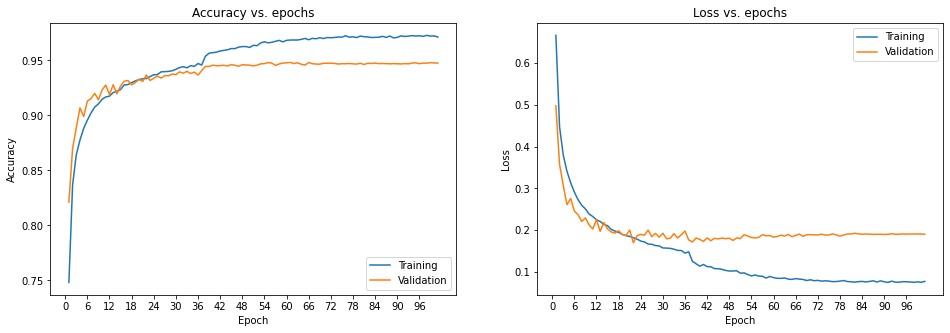

2021-08-10 17:36:52,765: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 17:37:10,493: INFO: test loss:0.1845
2021-08-10 17:37:10,494: INFO: test accuracy:0.9481
2021-08-10 17:37:10,496: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 17:37:10,498: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 17:37:10,499: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 17:37:10,500: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 17:37:10,500: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 17:37:11,729: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


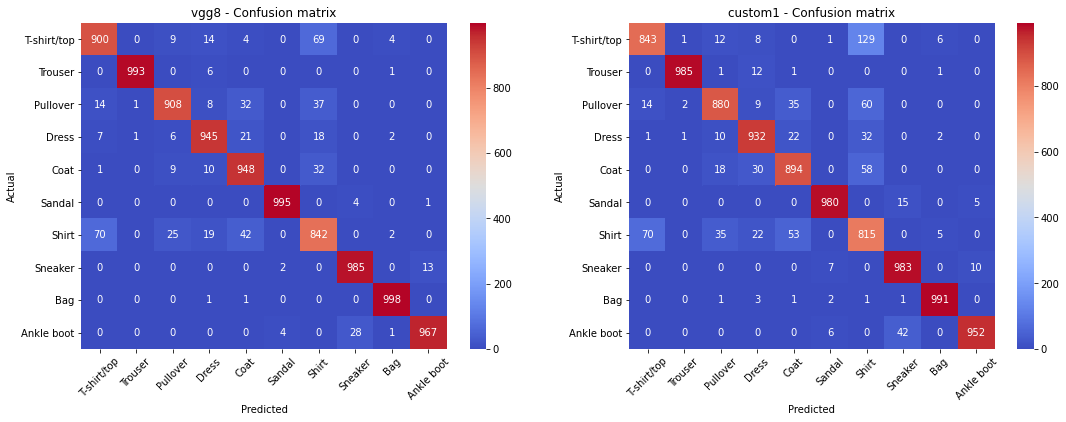

2021-08-10 17:37:15,664: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 17:37:16,622: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 17:37:16,625: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
2021-08-10 17:37:17,454: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 17:37:17,456: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/mlp1
2021-08-10 17:37:17,738: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


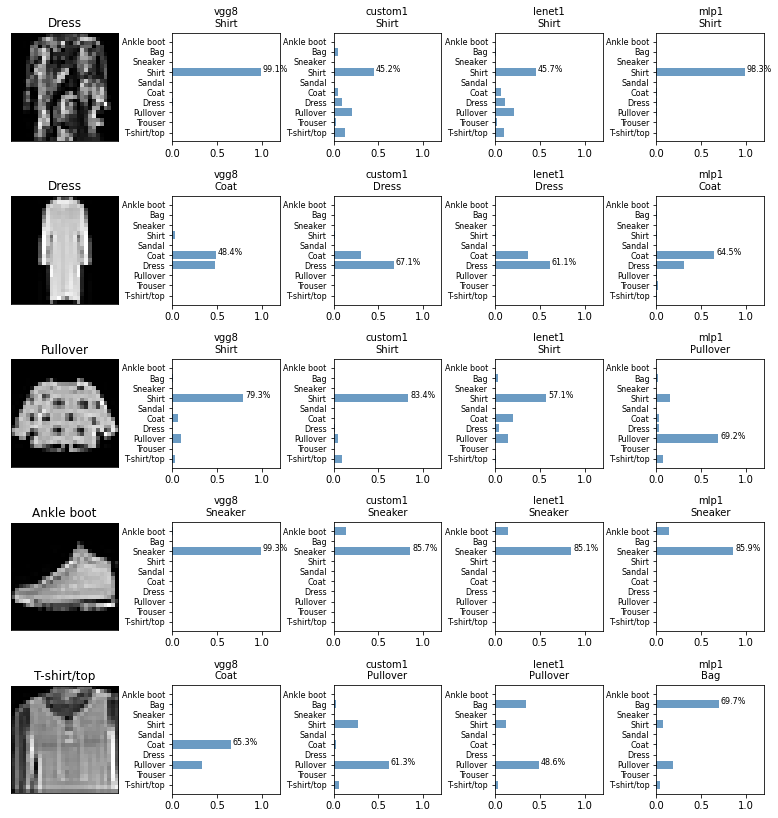

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,3114.9,2021-08-10 17:37,0.0481,0.1845,0.9819,0.9481,0.9997,0.9975
2,custom1,73162,2542.9,2021-08-10 16:44,0.1595,0.2080,0.9392,0.9255,0.9973,0.9958
3,lenet1,61750,2497.6,2021-08-10 16:02,0.1795,0.2320,0.9315,0.9144,0.9967,0.9949
4,mlp1,101770,2391.2,2021-08-10 15:20,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2021-08-10 17:37:23,760: INFO: learning_rate=0.001
2021-08-10 17:37:23,760: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 17:37:23,768: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20
2021-08-10 17:37:23,787: INFO: model_params.resnet_v1_20.epochs=120
2021-08-10 17:37:23,788: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20, monitor=val_accuracy)
2021-08-10 17:37:23,789: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 17:37:23,789: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 17:37:23,790: INFO: use LearningRateScheduler()
2021-08-10 17:37:23,790: INFO: steps_per_epoch=1875
2021-08-10 17:37:23,791: INFO: start training
2021-08-10 17:37:23,791: INFO: use_class_

Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 28, 28, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1875/1875 [==============================] - 49s 25ms/step - loss: 0.6914 - accuracy: 0.7987 - val_loss: 0.5531 - val_accuracy: 0.8464


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:38:25,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 2/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.4882 - accuracy: 0.8691 - val_loss: 0.5261 - val_accuracy: 0.8539


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:39:23,085: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 3/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.4359 - accuracy: 0.8854 - val_loss: 0.4669 - val_accuracy: 0.8720


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:40:19,578: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 4/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.4021 - accuracy: 0.8931 - val_loss: 0.4677 - val_accuracy: 0.8791


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:41:17,454: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 5/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3807 - accuracy: 0.9000 - val_loss: 0.3774 - val_accuracy: 0.9011


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:42:14,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 6/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3660 - accuracy: 0.9029 - val_loss: 0.4040 - val_accuracy: 0.8932
Epoch 7/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3547 - accuracy: 0.9064 - val_loss: 0.4849 - val_accuracy: 0.8596
Epoch 8/120
1875/1875 [==============================] - 46s 24ms/step - loss: 0.3439 - accuracy: 0.9088 - val_loss: 0.3772 - val_accuracy: 0.8959
Epoch 9/120
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3355 - accuracy: 0.9125 - val_loss: 0.3521 - val_accuracy: 0.9081


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:45:29,821: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 10/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3287 - accuracy: 0.9142 - val_loss: 0.3437 - val_accuracy: 0.9081
Epoch 11/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3213 - accuracy: 0.9165 - val_loss: 0.3968 - val_accuracy: 0.8944
Epoch 12/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3147 - accuracy: 0.9182 - val_loss: 0.3516 - val_accuracy: 0.9051
Epoch 13/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3103 - accuracy: 0.9204 - val_loss: 0.3931 - val_accuracy: 0.8910
Epoch 14/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3060 - accuracy: 0.9208 - val_loss: 0.3548 - val_accuracy: 0.9036
Epoch 15/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3019 - accuracy: 0.9218 - val_loss: 0.3372 - val_accuracy: 0.9053
Epoch 16/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2988 - accuracy: 0.9237 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:51:05,360: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 17/120
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2957 - accuracy: 0.9253 - val_loss: 0.3380 - val_accuracy: 0.9119


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:52:03,835: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 18/120
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2921 - accuracy: 0.9241 - val_loss: 0.2984 - val_accuracy: 0.9232


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 17:53:05,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 19/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2883 - accuracy: 0.9255 - val_loss: 0.3687 - val_accuracy: 0.9011
Epoch 20/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2875 - accuracy: 0.9251 - val_loss: 0.3050 - val_accuracy: 0.9211
Epoch 21/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2830 - accuracy: 0.9282 - val_loss: 0.3109 - val_accuracy: 0.9184
Epoch 22/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2831 - accuracy: 0.9269 - val_loss: 0.3300 - val_accuracy: 0.9124
Epoch 23/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2794 - accuracy: 0.9283 - val_loss: 0.3561 - val_accuracy: 0.9041
Epoch 24/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2789 - accuracy: 0.9291 - val_loss: 0.3320 - val_accuracy: 0.9159
Epoch 25/120
1875/1875 [==============================] - 53s 29ms/step - loss: 0.2779 - accuracy: 0.9283 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:09:09,432: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 37/120
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2636 - accuracy: 0.9323 - val_loss: 0.2957 - val_accuracy: 0.9232
Epoch 38/120
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2620 - accuracy: 0.9334 - val_loss: 0.3572 - val_accuracy: 0.9012
Epoch 39/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2617 - accuracy: 0.9342 - val_loss: 0.2898 - val_accuracy: 0.9252
Epoch 40/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2579 - accuracy: 0.9337 - val_loss: 0.3080 - val_accuracy: 0.9182
Epoch 41/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2564 - accuracy: 0.9349 - val_loss: 0.2986 - val_accuracy: 0.9177
Epoch 42/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2568 - accuracy: 0.9352 - val_loss: 0.2872 - val_accuracy: 0.9260
Epoch 43/120
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2560 - accuracy: 0.9353 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:26:05,357: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 56/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2463 - accuracy: 0.9379 - val_loss: 0.2899 - val_accuracy: 0.9251
Epoch 57/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2459 - accuracy: 0.9387 - val_loss: 0.2868 - val_accuracy: 0.9271
Epoch 58/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2462 - accuracy: 0.9376 - val_loss: 0.3043 - val_accuracy: 0.9215
Epoch 59/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2446 - accuracy: 0.9385 - val_loss: 0.3032 - val_accuracy: 0.9172
Epoch 60/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2472 - accuracy: 0.9374 - val_loss: 0.2805 - val_accuracy: 0.9236
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2096 - accuracy: 0.9514 - val_loss: 0.2464 - val_accuracy: 0.9384


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:31:33,988: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 62/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1963 - accuracy: 0.9554 - val_loss: 0.2438 - val_accuracy: 0.9384
Epoch 63/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1881 - accuracy: 0.9580 - val_loss: 0.2439 - val_accuracy: 0.9397


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:33:31,433: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 64/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1844 - accuracy: 0.9591 - val_loss: 0.2418 - val_accuracy: 0.9395
Epoch 65/120
1875/1875 [==============================] - 54s 29ms/step - loss: 0.1816 - accuracy: 0.9597 - val_loss: 0.2386 - val_accuracy: 0.9405


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:35:30,198: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 66/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1759 - accuracy: 0.9613 - val_loss: 0.2394 - val_accuracy: 0.9386
Epoch 67/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1726 - accuracy: 0.9618 - val_loss: 0.2344 - val_accuracy: 0.9424


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:37:28,510: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 68/120
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1693 - accuracy: 0.9625 - val_loss: 0.2367 - val_accuracy: 0.9412
Epoch 69/120
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1660 - accuracy: 0.9631 - val_loss: 0.2377 - val_accuracy: 0.9421
Epoch 70/120
1875/1875 [==============================] - 54s 29ms/step - loss: 0.1629 - accuracy: 0.9649 - val_loss: 0.2361 - val_accuracy: 0.9423
Epoch 71/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1611 - accuracy: 0.9647 - val_loss: 0.2353 - val_accuracy: 0.9417
Epoch 72/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1596 - accuracy: 0.9649 - val_loss: 0.2334 - val_accuracy: 0.9438


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


2021-08-10 18:42:08,255: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20/assets


Epoch 73/120
1875/1875 [==============================] - 54s 29ms/step - loss: 0.1560 - accuracy: 0.9663 - val_loss: 0.2320 - val_accuracy: 0.9425
Epoch 74/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1543 - accuracy: 0.9665 - val_loss: 0.2360 - val_accuracy: 0.9408
Epoch 75/120
1875/1875 [==============================] - 54s 29ms/step - loss: 0.1512 - accuracy: 0.9666 - val_loss: 0.2390 - val_accuracy: 0.9416
Epoch 76/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1499 - accuracy: 0.9665 - val_loss: 0.2335 - val_accuracy: 0.9435
Epoch 77/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1475 - accuracy: 0.9679 - val_loss: 0.2333 - val_accuracy: 0.9435
Epoch 78/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1469 - accuracy: 0.9679 - val_loss: 0.2343 - val_accuracy: 0.9431
Epoch 79/120
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1458 - accuracy: 0.9681 - val_

2021-08-10 19:12:04,562: INFO: finish training [elapsed time: 5680.77 seconds]


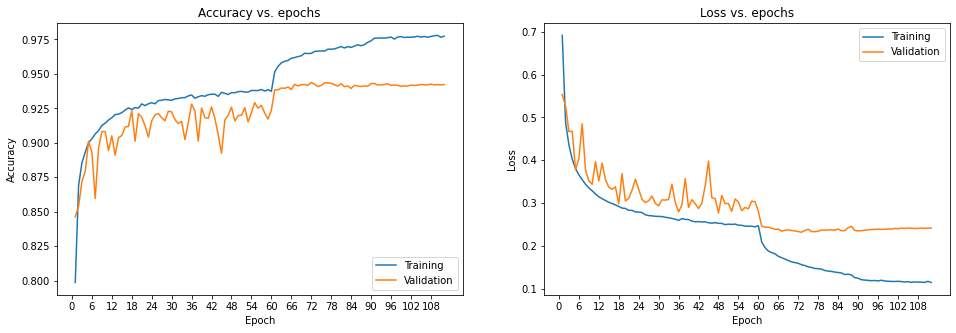

2021-08-10 19:12:05,065: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 19:12:39,012: INFO: test loss:0.2334
2021-08-10 19:12:39,012: INFO: test accuracy:0.9438
2021-08-10 19:12:39,017: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 19:12:39,019: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json
2021-08-10 19:12:39,020: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:12:39,021: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:12:39,021: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 19:12:41,180: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator


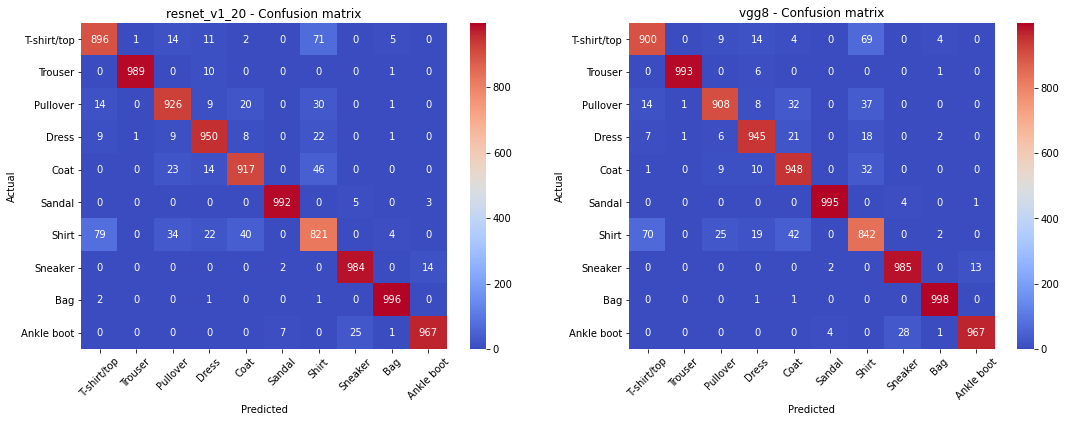

2021-08-10 19:12:46,180: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 19:12:47,718: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:12:47,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/custom1
2021-08-10 19:12:48,643: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:12:48,647: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/lenet1
2021-08-10 19:12:49,427: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:12:49,4

2021-08-10 19:12:52,742: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9c08559d90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


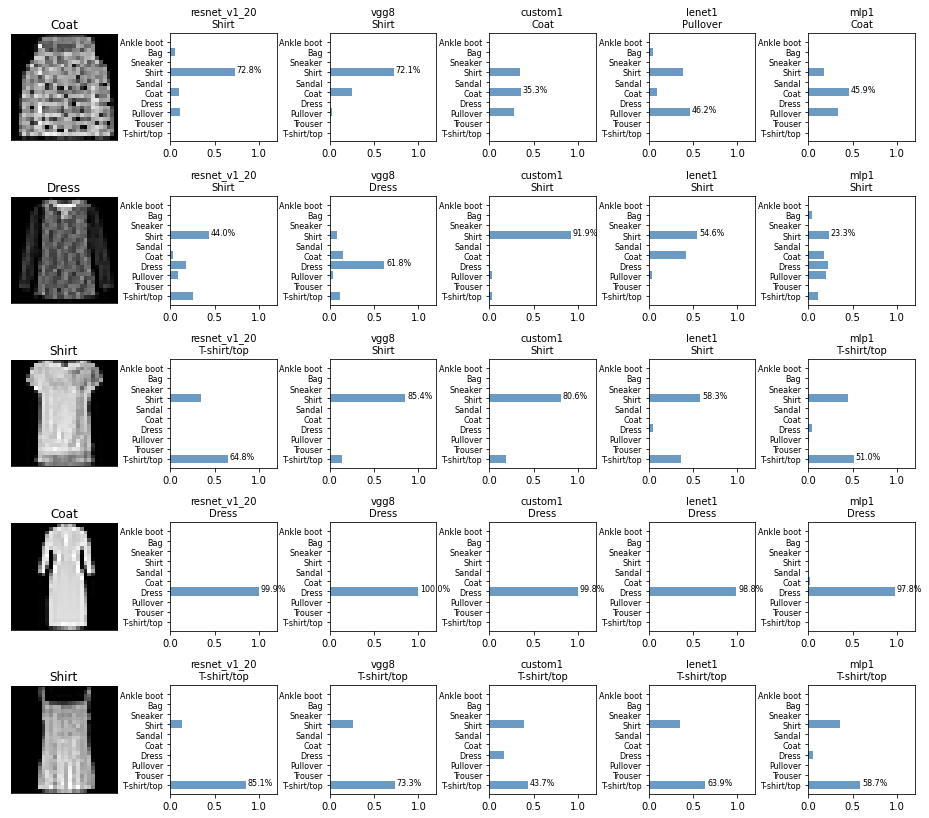

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,3114.9,2021-08-10 17:37,0.0481,0.1845,0.9819,0.9481,0.9997,0.9975
2,resnet_v1_20,272778,5680.3,2021-08-10 19:12,0.1473,0.2334,0.9695,0.9438,0.9991,0.9971
3,custom1,73162,2542.9,2021-08-10 16:44,0.1595,0.2080,0.9392,0.9255,0.9973,0.9958
4,lenet1,61750,2497.6,2021-08-10 16:02,0.1795,0.2320,0.9315,0.9144,0.9967,0.9949
5,mlp1,101770,2391.2,2021-08-10 15:20,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [22]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-10 19:12:57,005: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist
2021-08-10 19:12:57,007: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 19:12:57,008: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,create_time
1,vgg8,1442378,4493.5,0.0061,0.2876,0.9983,0.9488,1.0000,0.9974,NaN
2,vgg8,1442378,3114.9,0.0481,0.1845,0.9819,0.9481,0.9997,0.9975,2021-08-10 17:37
3,resnet_v1_20,272778,5680.3,0.1473,0.2334,0.9695,0.9438,0.9991,0.9971,2021-08-10 19:12
4,custom1,73162,1699.4,0.1025,0.1928,0.9617,0.9335,0.9988,0.9965,NaN
5,resnet_v1_20,272778,5185.5,0.1309,0.4153,0.9957,0.9267,1.0000,0.9954,2021-08-10 12:10
6,custom1,73162,2542.9,0.1595,0.2080,0.9392,0.9255,0.9973,0.9958,2021-08-10 16:44
7,lenet1,61750,1149.5,0.1069,0.2168,0.9607,0.9241,0.9987,0.9957,NaN
8,lenet1,61750,2497.6,0.1795,0.2320,0.9315,0.9144,0.9967,0.9949,2021-08-10 16:02
9,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913,NaN
10,mlp1,101770,2391.2,0.2961,0.3483,0.8911,0.8806,0.9915,0.9890,2021-08-10 15:20


2021-08-10 19:12:57,109: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8
2021-08-10 19:12:58,818: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 19:12:58,821: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/vgg8
2021-08-10 19:13:00,812: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/val_test.generator
2021-08-10 19:13:00,814: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100_aug/resnet_v1_20
2021-08-10 19:13:05,792: INFO: loading genera

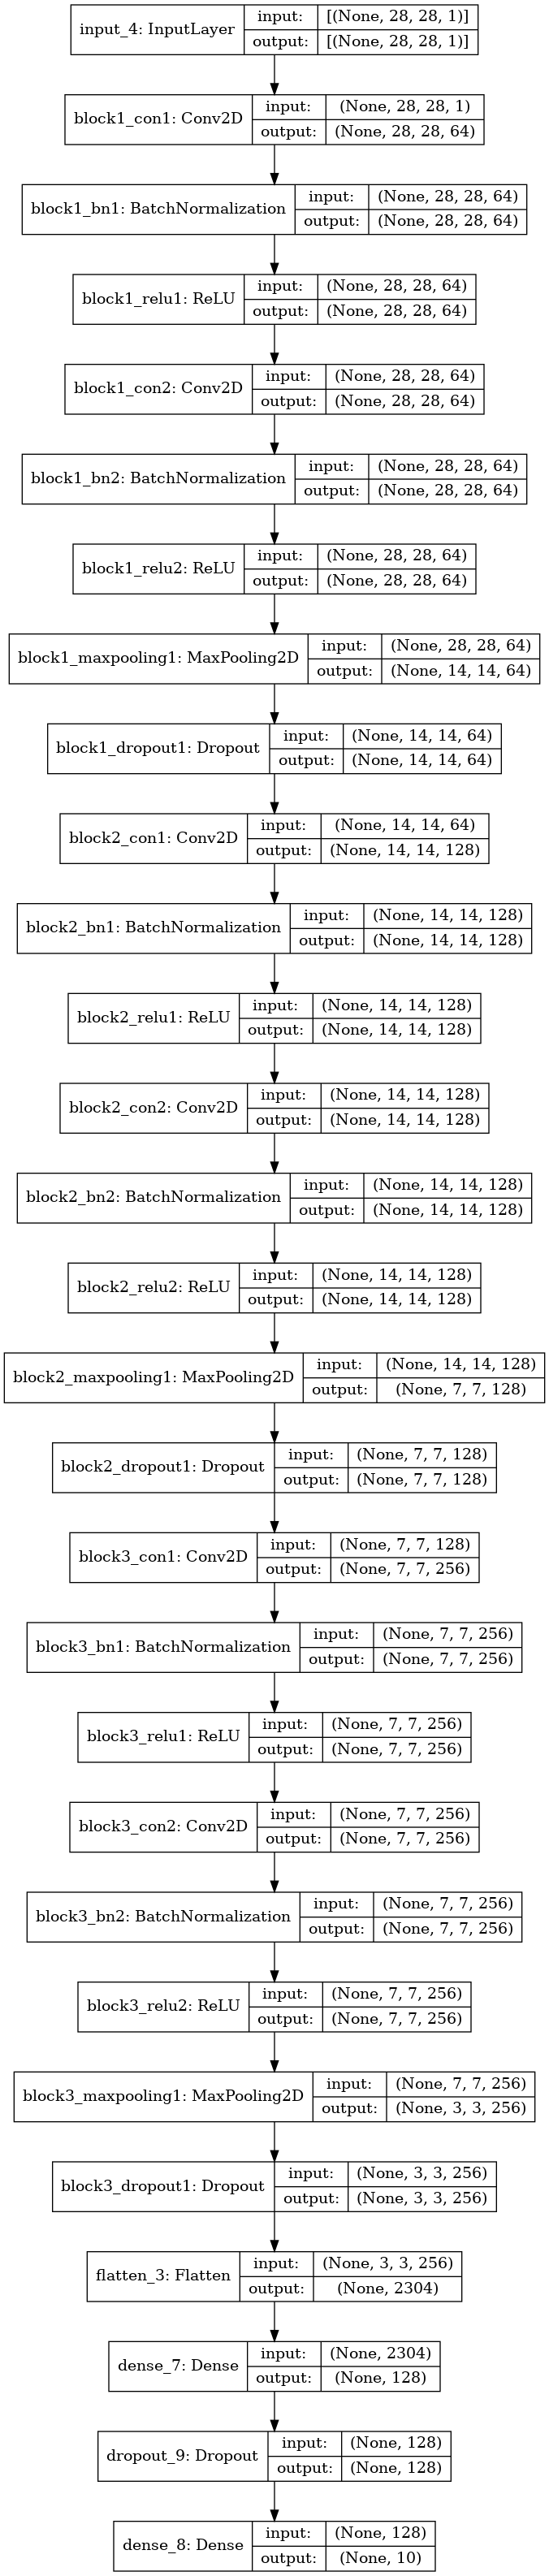

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2021-08-10 19:13:13,512: WARNING: 5 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9dc4fa40d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


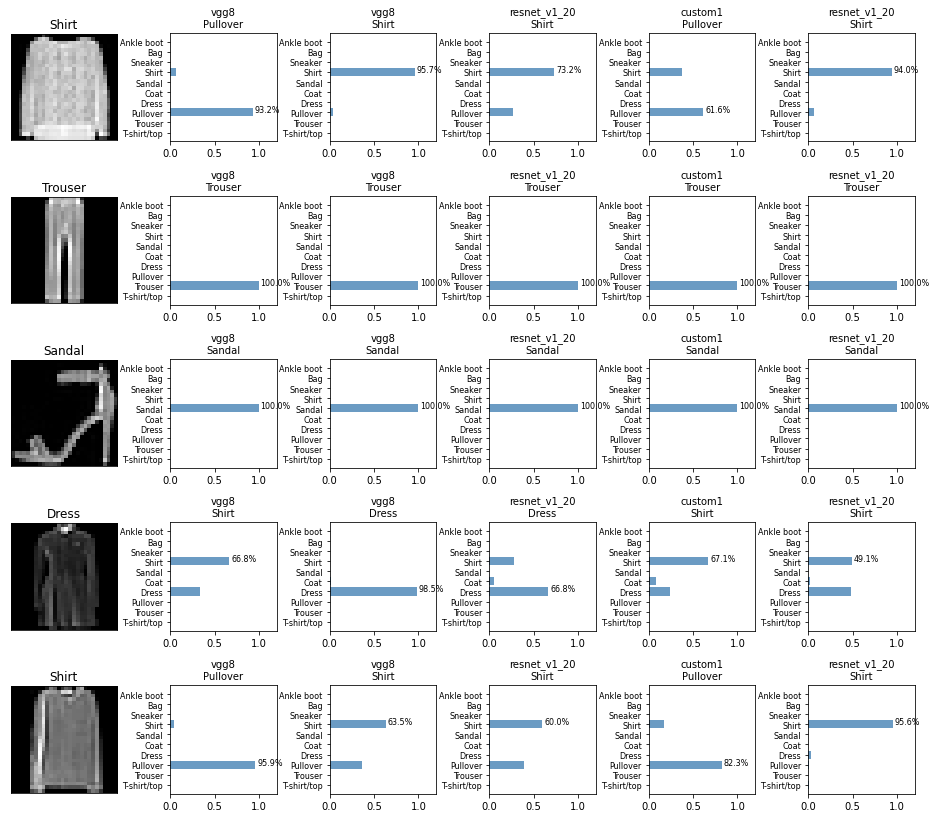

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

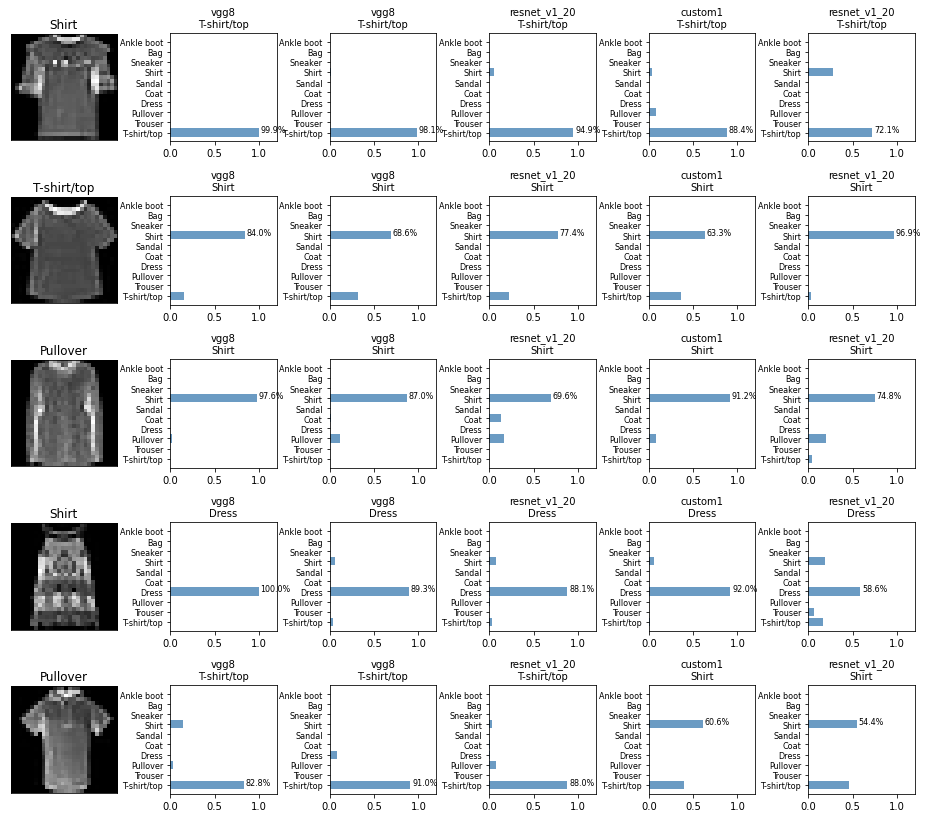

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.2875531017780304, 'accuracy': 0.9488000273704529, 'mae': 39.69039535522461}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
T-shirt/top,0.922360,0.891,0.906409
Trouser,0.995976,0.990,0.992979
Pullover,0.935354,0.926,0.930653
Dress,0.945219,0.949,0.947106
Coat,0.904489,0.947,0.925256
Sandal,0.992965,0.988,0.990476
Shirt,0.840841,0.840,0.840420
Sneaker,0.974283,0.985,0.979612
Bag,0.994000,0.994,0.994000
Ankle boot,0.983903,0.978,0.980943


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 T-shirt/top     0.9224    0.8910    0.9064      1000
     Trouser     0.9960    0.9900    0.9930      1000
    Pullover     0.9354    0.9260    0.9307      1000
       Dress     0.9452    0.9490    0.9471      1000
        Coat     0.9045    0.9470    0.9253      1000
      Sandal     0.9930    0.9880    0.9905      1000
       Shirt     0.8408    0.8400    0.8404      1000
     Sneaker     0.9743    0.9850    0.9796      1000
         Bag     0.9940    0.9940    0.9940      1000
  Ankle boot     0.9839    0.9780    0.9809      1000

    accuracy                         0.9488     10000
   macro avg     0.9489    0.9488    0.9488     10000
weighted avg     0.9489    0.9488    0.9488     10000



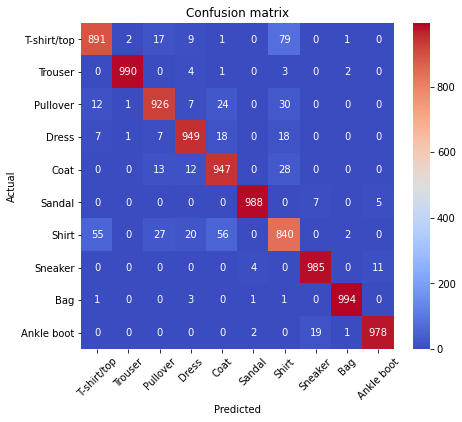

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.keras.preprocessing.image.NumpyArrayIterator